In [20]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, resnet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy

In [21]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohamedhanyyy/chest-ctscan-images")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-ctscan-images' dataset.
Path to dataset files: /kaggle/input/chest-ctscan-images


## Mixed Precision for Efficiency

**Mixed Precision** is a technique that uses both **16-bit** and **32-bit** floating point numbers during training to improve performance while reducing memory usage. In this section, we enable mixed precision training using TensorFlow:


In [22]:
# Mixed Precision for Efficiency
tf.keras.mixed_precision.set_global_policy('mixed_float16')

## Setting Paths and Configuration Parameters

In this section, we define the paths to the dataset and configuration parameters for training the model:

### Paths:
- **train_path**: The directory containing the training images.
- **valid_path**: The directory containing the validation images.
- **test_path**: The directory containing the test images.

In [23]:
# Paths
train_path = "/kaggle/input/chest-ctscan-images/Data/train"
valid_path = "/kaggle/input/chest-ctscan-images/Data/valid"
test_path  = "/kaggle/input/chest-ctscan-images/Data/test"
BATCH_SIZE = 32
IMG_SHAPE = (460, 460)

This code will load an image from the given file path, resize it to the target shape of 224x224 pixels, and then display the image using Matplotlib. It also prints the shape of the resized image, which should be (224, 224, 3) for RGB images. Here’s a breakdown of the code:

PIL is used to load and resize the image.
The image is then converted into a NumPy array to work with it for model input.
The image is displayed using Matplotlib, with the axis turned off for better visualization.
Finally, the shape of the resized image is printed to confirm it matches the target size.

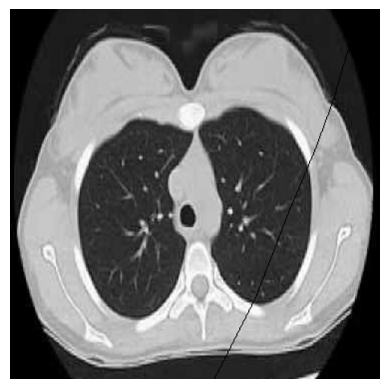

Resized image shape: (460, 460, 4)


In [24]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "/kaggle/input/chest-ctscan-images/Data/train/normal/10 (2) - Copy.png"
img = Image.open(image_path)

# Resize the image to 460,460
img_resized = img.resize((460, 460))

# Convert image to numpy array
img_array = np.array(img_resized)

# Show the resized image
plt.imshow(img_array)
plt.axis('off')
plt.show()

# Check the new shape of the image
print("Resized image shape:", img_array.shape)


## This code defines a data augmentation pipeline
using the ImageDataGenerator class from Keras. Data augmentation helps to artificially expand the dataset by applying random transformations to the images, which can improve model generalization and reduce overfitting.

Explanation of Parameters:
- preprocessing_function=resnet50.preprocess_input: This function preprocesses the image in the same way as ResNet50 expects, scaling pixel values accordingly (e.g., subtracting the mean RGB values and dividing by the standard deviation).
- rotation_range=20: Randomly rotates the images by a maximum of 20 degrees, making the model more invariant to image orientation.
- horizontal_flip=True: Randomly flips the images horizontally. This is helpful when the orientation of the object doesn't matter, like in the case of chest CT scans.
- zoom_range=0.2: Randomly zooms in on the images within a range of 0.2 (20% zoom), helping the model to be more robust to varying image scales.
- shear_range=0.2: Randomly applies shear transformations, which can simulate the effect of slanted objects, improving the model's ability to generalize.
- brightness_range=[0.8, 1.2]: Randomly adjusts the brightness of the images, helping the model learn to recognize features under different lighting conditions.

In [25]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=resnet50.preprocess_input,
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8,1.2]
)

## Data Preprocessing and Loading for Training and Validation

- Using ImageDataGenerator to preprocess and augment images in real-time during training.
- This is essential to ensure that the model receives varied and appropriately scaled data.

#### Initialize ImageDataGenerator for validation data with only preprocessing
valid_datagen = ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)

#### Training data generator with augmentation to improve generalization
train_generator = train_datagen.flow_from_directory(
    train_path,  # Path to the training images directory
    target_size=IMG_SHAPE,  # Resizing images to 224


In [26]:
valid_datagen = ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_path, target_size=IMG_SHAPE, batch_size=BATCH_SIZE, class_mode='categorical'
)
valid_generator = valid_datagen.flow_from_directory(
    valid_path, target_size=IMG_SHAPE, batch_size=BATCH_SIZE, class_mode='categorical'
)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


## Model Setup: Using ResNet50 as the Base Model

In this section, we are using the pre-trained **ResNet50** model as a feature extractor for our new task. We will freeze most of the layers to prevent overfitting and only fine-tune the last block, **conv5**, to adapt the model to the new dataset.

### Code Explanation:

1. **Input Tensor:**
   - We specify the input shape for the model, which is `(460, 460, 3)` where `460*460` is the image resolution and `3` represents the RGB color channels.
   
   ```python
   input_tensor = Input(shape=(460, 460, 3))


In [27]:
input_tensor = Input(shape=(460, 460, 3))
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)

# Freeze most layers except conv5 block
for layer in base_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


## Adding Custom Classifier Layers to the Base Model

In this section, we modify the output of the **ResNet50** base model by adding custom layers tailored for our specific task. The goal is to create a model that takes advantage of the pre-trained ResNet50 feature extractor, then adds a custom classification layer to make predictions for our dataset.

### Code Explanation:

1. **Base Model Output:**
   - We start by extracting the output of the base model (ResNet50). This serves as the input to the new classifier we are building on top of the ResNet50 model.
   
   ```python
   x = base_model.output


In [28]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
output = Dense(4, activation='softmax', dtype='float32')(x)  # Restore float32 at output

## Final Model Creation and Summary

In this section, we define the complete model by combining the pre-trained **ResNet50** model (with the custom layers added) and then print a summary of the model architecture.

### Code Explanation:

1. **Model Definition:**
   - We define the full model by specifying the input layer from the pre-trained ResNet50 model and the output layer from the custom classifier (which we built in the previous step).
   
   ```python
   model = Model(inputs=base_model.input, outputs=output)


In [29]:
model = Model(inputs=base_model.input, outputs=output)
# model.summary()

## Model Compilation

In this section, we compile the model by defining the learning rate schedule, loss function, and optimizer.

### Code Explanation:

1. **Learning Rate Schedule:**
   - We use the **ExponentialDecay** function to set the learning rate schedule. This function gradually decreases the learning rate as training progresses, helping the model converge more efficiently and avoid overshooting the optimal solution.
   ```python
   lr_schedule = ExponentialDecay(initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.95)


In [30]:
# Compile
lr_schedule = ExponentialDecay(initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.95)
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
optimizer = Adam(learning_rate=lr_schedule)

## Model Compilation

In this section, we compile the model by defining the learning rate schedule, loss function, and optimizer.

### Code Explanation:

1. **Learning Rate Schedule:**
   - We use the **ExponentialDecay** function to set the learning rate schedule. This function gradually decreases the learning rate as training progresses, helping the model converge more efficiently and avoid overshooting the optimal solution.
   ```python
   lr_schedule = ExponentialDecay(initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.95)


In [31]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

## Callbacks for Model Training

In this section, we define callbacks that will help monitor the model's performance during training and take actions such as saving the best model, early stopping, and reducing the learning rate if necessary.

### Code Explanation:

1. **ModelCheckpoint:**
   - This callback saves the model at regular intervals during training. The model will only be saved if the validation loss improves, ensuring that only the best model (in terms of validation loss) is saved.
   ```python
   checkpoint = ModelCheckpoint("chest_resnet50.keras", save_best_only=True, monitor='val_loss', verbose=1)


In [32]:
# Callbacks
checkpoint = ModelCheckpoint("chest_resnet50.keras", save_best_only=True, monitor='val_loss', verbose=1)
earlystop = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)

## Model Training

In this section, we train the model using the previously defined generators for training and validation data. We also apply the callbacks for better model performance during training.

In [33]:
# Train
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[checkpoint, earlystop, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4762 - loss: 1.5334
Epoch 1: val_loss improved from inf to 1.32347, saving model to chest_resnet50.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - accuracy: 0.4806 - loss: 1.5220 - val_accuracy: 0.3889 - val_loss: 1.3235 - learning_rate: 9.9990e-05
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7888 - loss: 0.8518
Epoch 2: val_loss did not improve from 1.32347
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7897 - loss: 0.8493 - val_accuracy: 0.5000 - val_loss: 1.5543 - learning_rate: 9.9979e-05
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8910 - loss: 0.6730
Epoch 3: val_loss improved from 1.32347 to 1.17065, saving model to chest_resnet50.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8911 - loss: 0.6715 - val_accuracy: 0.6250 - val_loss: 1.1707 - learning_rate: 9.9969e-05
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9245 - loss: 0.5914
Epoch 4: val_loss

In [38]:
model.save("chest_resnet50_v1.keras")

## Model Training Report
The model was trained for 15 epochs with the following setup:

- Learning Rate Schedule: Exponential decay with an initial learning rate of 1e-4.
- Callbacks:
- ModelCheckpoint: Saved the best model based on validation loss.
- EarlyStopping: Stopped training early if the validation loss did not improve for 10 consecutive epochs.
- ReduceLROnPlateau: Reduced the learning rate when the validation loss plateaued.

Found 315 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step


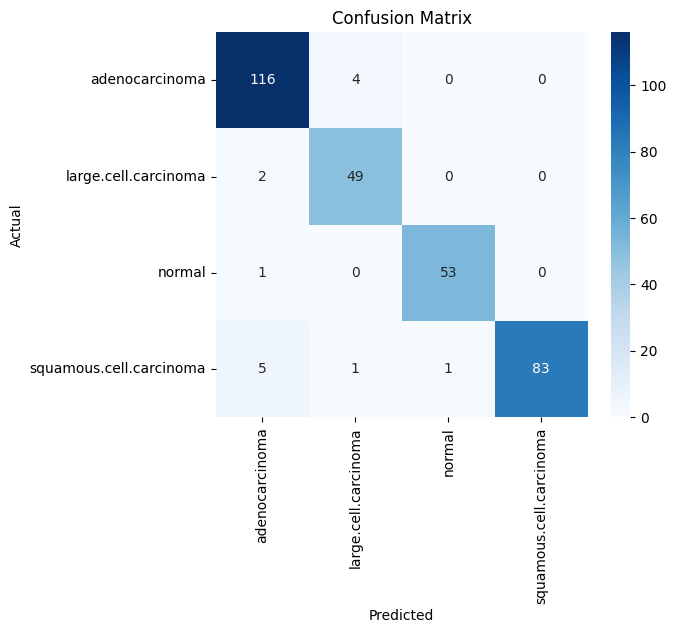

📊 Performance Metrics:
Accuracy : 0.9556
Precision: 0.9573
Recall   : 0.9556
F1-Score : 0.9557


In [34]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
# Data generator untuk test set
test_datagen = ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Ambil nama kelas
class_names = list(test_generator.class_indices.keys())

# Prediksi di data test
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes  # kelas asli

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Hitung metric
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)

print("📊 Performance Metrics:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")


## The code you shared will generate two plots to visualize the training progress of your model:

- Model Accuracy Plot: This plot will show the training and validation accuracy over the epochs, which helps in understanding how well the model is learning and generalizing to unseen data.
- Model Loss Plot: This plot will display the training and validation loss over the epochs, indicating how well the model is minimizing the loss during training and whether it's overfitting or underfitting.

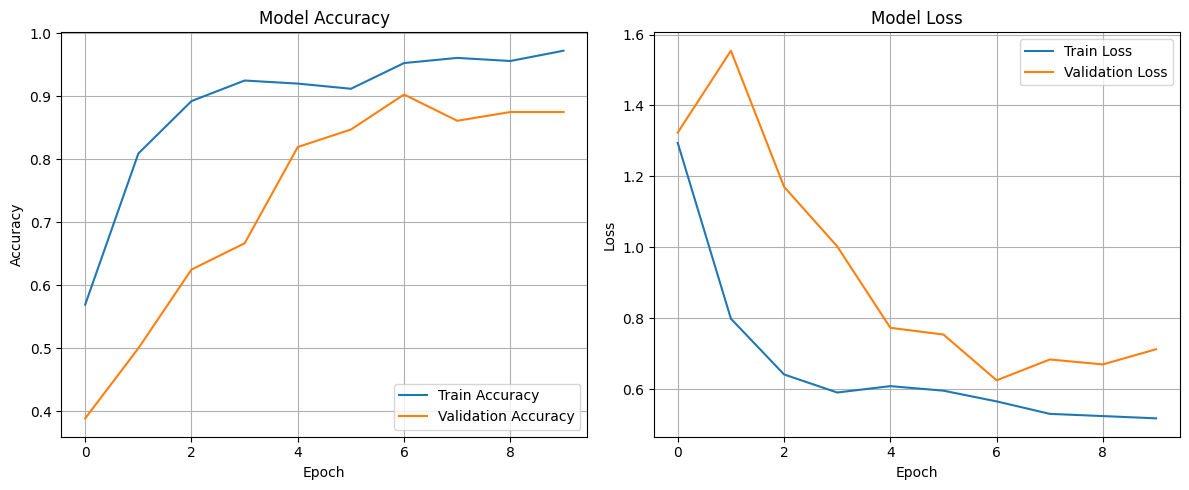

In [35]:
import matplotlib.pyplot as plt

# Plotting Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


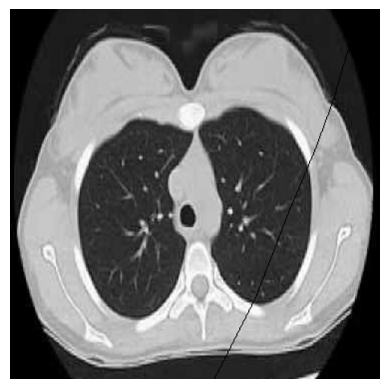

In [36]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image from the specified path
image_path = "/kaggle/input/chest-ctscan-images/Data/train/normal/10 (2) - Copy.png"
img = Image.open(image_path)

# Resize the image to 460x460
img_resized = img.resize((460, 460))

# Display the resized image
plt.imshow(img_resized)
plt.axis('off')  # Hide axes
plt.show()

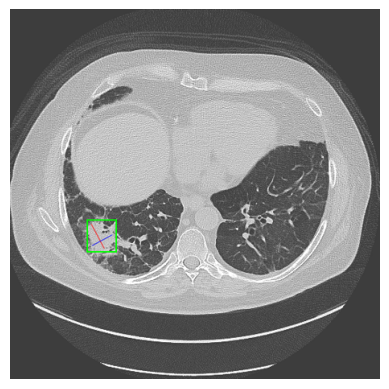

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted class: adenocarcinoma


In [52]:
### Run the Inference/Prediction
#-------------------------------

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load the image from the specified path
#image_path = "/kaggle/input/chest-ctscan-images/Data/test/squamous.cell.carcinoma/000108 (6).png"

image_path = "003828_02_01_174.png"
img = Image.open(image_path)

# Convert the image to RGB
img_rgb = img.convert("RGB")

# Resize the image to 460x460
img_resized = img_rgb.resize((460, 460))

# Display the resized image
plt.imshow(img_resized)
plt.axis('off')
plt.show()

# Convert the image to a numpy array
img_array = np.array(img_resized)

# Add an extra dimension to the image (for batch size)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image
img_preprocessed = preprocess_input(img_array)

# Make a prediction
prediction = model.predict(img_preprocessed)

# Get the predicted class
predicted_class = np.argmax(prediction, axis=1)

# Optionally, map the predicted class to the actual class label if you have a class dictionary
class_labels = {0: 'adenocarcinoma', 1: 'large.cell.carcinoma', 2: 'normal', 3: 'squamous.cell.carcinoma'}  # Example labels
predicted_label = class_labels[predicted_class[0]]

print("Predicted class:", predicted_label)

### 1. Adenocarcinoma (Label 0):
Adenocarcinoma is a type of non-small cell lung cancer (NSCLC), which is the most common type of lung cancer. It usually starts in the cells that line the alveoli (air sacs) and produce mucus. It is often found in the outer parts of the lungs and is more common in non-smokers.
Characteristics: It tends to grow more slowly compared to other types of lung cancer and has a better prognosis when detected early.
### 2. Large Cell Carcinoma (Label 1):
Large Cell Carcinoma is another type of non-small cell lung cancer. It is known for its large, abnormal-looking cells. It can appear in any part of the lung and tends to grow and spread quickly.
Characteristics: This cancer type is generally harder to treat due to its fast growth rate and the fact that it can spread early in its development.
### 3. Normal (Label 2):
Normal refers to healthy, non-cancerous lung tissue. This is used in the context of a dataset where the model is trained to distinguish between cancerous and non-cancerous tissue.
### 4. Squamous Cell Carcinoma (Label 3):
Squamous Cell Carcinoma is another form of non-small cell lung cancer. It begins in the squamous cells that line the airways of the lungs. This type of cancer is strongly associated with smoking.
Characteristics: It is often diagnosed in people who have a history of smoking and tends to form near the central part of the lungs, in the bronchi.

Last Conv Layer: conv5_block3_3_conv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted class: normal


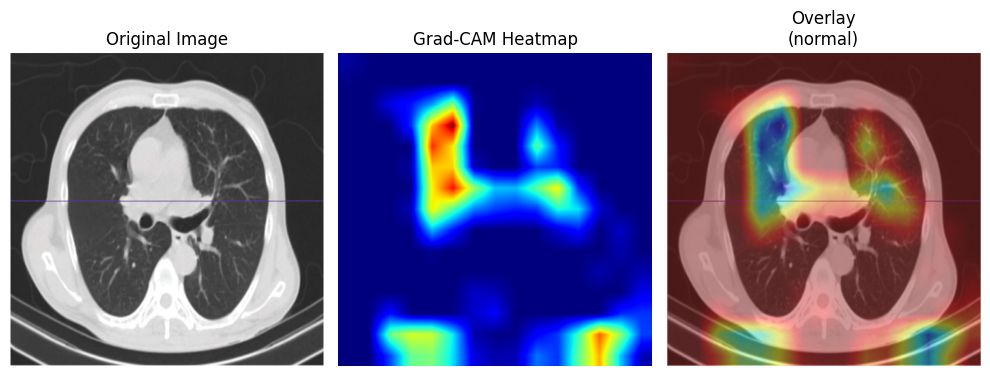

In [45]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Conv2D
from PIL import Image

# ===== Fungsi untuk cari last conv layer =====
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, Conv2D):
            return layer.name
    raise ValueError("Tidak menemukan layer Conv2D terakhir di model.")

# ===== Fungsi Grad-CAM =====
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalisasi 0–1 dengan aman
    heatmap = tf.maximum(heatmap, 0)
    denom = tf.reduce_max(heatmap) + tf.keras.backend.epsilon()
    heatmap = heatmap / denom
    return heatmap.numpy()

# ===== Cari layer conv terakhir =====
last_conv_layer_name = find_last_conv_layer(model)
print("Last Conv Layer:", last_conv_layer_name)

# ===== Path gambar =====
#test_image_path = "/kaggle/input/chest-ctscan-images/Data/test/large.cell.carcinoma/000147 (2).png"

test_image_path = "5.png"
# ===== Preprocess gambar =====
img = Image.open(test_image_path).convert("RGB").resize((460, 460))
img_array = np.array(img)
img_array_exp = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_array_exp)

# ===== Prediksi =====
preds = model.predict(img_preprocessed)
pred_class_index = np.argmax(preds[0])
pred_class_label = class_labels[pred_class_index]
print("Predicted class:", pred_class_label)

# ===== Buat heatmap =====
heatmap = make_gradcam_heatmap(img_preprocessed, model, last_conv_layer_name, pred_index=pred_class_index)

# ===== Cek & perbaiki heatmap =====
if heatmap is None or heatmap.size == 0:
    raise ValueError("Heatmap kosong. Periksa last_conv_layer_name.")

heatmap = np.nan_to_num(heatmap).astype(np.float32)  # Hindari NaN dan pastikan kompatibel OpenCV
if np.max(heatmap) > 0:
    heatmap /= np.max(heatmap)  # Normalisasi ulang jika perlu

# ===== Resize & overlay =====
heatmap_resized = cv2.resize(heatmap, (img.size[0], img.size[1]))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(np.array(img), 0.6, heatmap_colored, 0.4, 0)

# ===== Visualisasi =====
plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(heatmap_resized, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(superimposed_img)
plt.title(f"Overlay\n({pred_class_label})")
plt.axis('off')

plt.tight_layout()
plt.show()
